# Speaker Identification: Text Independent Context

The human speech signal conveys many levels of information.  At the base level it carries a message in words.  But at other levels, it conveys information about language, dialect, emotion, gender and identity of the speaker.  While the speech recognition systems aim to identify the words spoken in the speech, the goal of the speaker recognition system is to extract the identity of the speaker associated with the speech signal.

The broad area of speaker recognition emcompasses two more fundamental tasks. Speaker verification (also known as speaker authentication) is a task of determining whether a person is who she claims to be.  Speaker identification is a task of determining who is speaking from a known set of speakers.  The unknown speaker makes no identity claim so the system must perform a 1:N classification.

These tasks can be further divided into text dependent and text independent categories. In a text dependent system the recognition system has prior knowledge of the text being spoken to.  In a text independent the recognition system is agnostic to the associated text.

Our focus is the problem of speaker identification in the text independent context.  Further, we will concentrate this study on short speeches (usually 2-5 seconds) from a large number of speakers.


## Dataset and Data Exploration

Our choice of audio dataset is open source VoxForge dataset.  It is freely available under GNU General Public License.  VoxForge was set up to collect transcribed speech for use in Open Source Speech Recognition Engines ("SRE"s).  The dataset contains 1216 unique speaker’s multiple audio files in wav format.  Each speech is of short duration (2-10 seconds).  

The voxforge dataset contains few samples where the speakers are not known and hence grouped under anonymous category.  We decided to exclude these samples from our project since they just impede the learning.  During the pre-processing stage, the wav files are converted to Mel-frequency cepstral coefficients (MFCCs) matrix of shape 20x196x1.  MFCCs can approximate the human auditory system response more closely than the linearly-spaced frequency bands used in the normal cepstrum. We experimented with Filter Bank energies as alternate but our findings indicate that for the speaker recognition task, the MFCC provides better accuracy.  

In [81]:
import os
import glob
from pathlib import Path

%matplotlib inline
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [31]:
def fetch_voxforge_data():
    ''' Fetch tar archive hosted from s3 bucket and untar it. '''
    data_archive = K.utils.get_file('voxforge.tar', 
                                'https://speaker-recognition.s3.amazonaws.com/voxforge.tar',
                                extract=True,
                                archive_format='tar')
    return data_archive

In [32]:
# This can take long time the first time. The tar file is around 11 GB.
# The tar and its extract are stored in ~/.keras/datasets
# Subsequent request will be much quicker (approx 2-3 mins)
%time data_archive = fetch_voxforge_data()

CPU times: user 43.1 s, sys: 1min 24s, total: 2min 7s
Wall time: 2min 47s


In [33]:
# voxforge_root points to the root folder of the voxforge dataset.
voxforge_root = Path(os.path.join(Path(data_archive).parent, 'voxforge'))
voxforge_root

PosixPath('/Users/manishpandit/.keras/datasets/voxforge')

In [34]:
# each folder under root contains audio files for a speaker.
# the folder name is the name of the speaker.
# let's print few sample speaker names.
for item in [folder for folder in voxforge_root.glob("*") 
             if not str(folder).split('/')[-1].startswith('.')][:3]:
  print(item.name)

mk-20120531-ctv
ductapeguy-20070619-com
zlp-20100110-hpf


In [35]:
# create a tf.data.Dataset from file set
file_set = [str(item) for item in voxforge_root.glob('*/wav/*.wav') 
            if not str(item).split('/')[-1].startswith('.')]
list_ds = tf.data.Dataset.from_tensor_slices(file_set)
# each folder contains multiple wav files that belongs to that speaker.
# let's print few sample wav file paths.
for f in list_ds.take(3):
  print(f.numpy())

b'/Users/manishpandit/.keras/datasets/voxforge/mk-20120531-ctv/wav/a0369.wav'
b'/Users/manishpandit/.keras/datasets/voxforge/mk-20120531-ctv/wav/a0368.wav'
b'/Users/manishpandit/.keras/datasets/voxforge/mk-20120531-ctv/wav/a0363.wav'


In [38]:
def extract_speaker(file_path):
    ''' extract speaker name from the file path '''
    return tf.strings.split(file_path, '/')[-3]

In [39]:
# create speaker dataset
speaker_ds = list_ds.map(
    lambda x: tf.py_function(extract_speaker, [x], tf.string))

In [40]:
# create lookup tables for speaker and their id
unique_speakers = set([bytes.decode(s.numpy()) for s in speaker_ds])
speaker2idx = {s : i for s, i in zip(unique_speakers, range(len(unique_speakers)))}
idx2speaker = {i : s for s, i in speaker2idx.items()}

In [41]:
def encode_speaker(speaker_ds):
    ''' converts the string based speaker dataset to categorical dataset '''
    return tf.data.Dataset.from_tensor_slices(K.utils.to_categorical([speaker2idx[bytes.decode(s.numpy())] for s in speaker_ds]))

In [42]:
# encoded speaker dataset
speaker_ds = speaker_ds.apply(encode_speaker)

In [43]:
# each speaker is now a one-hot vector
for s in speaker_ds.take(1):
    print(s.numpy())

[0. 0. 0. ... 0. 0. 0.]


In [36]:
def wav2mfcc(file_path, max_pad_len=196):
    ''' convert wav file to mfcc matrix with truncation and padding '''
    wave, sample_rate = librosa.load(file_path, mono=True, sr=None)
    mfcc = librosa.feature.mfcc(wave, sample_rate)
    mfcc = mfcc[:, :max_pad_len]
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

### Let's listen to a clip from the dataset.

In [74]:
sample_audio = os.path.join(voxforge_root, 'chocoholic-20070523/wav/rom0001.wav')
import IPython.display as ipd
ipd.Audio(sample_audio)

### Plot the audio array

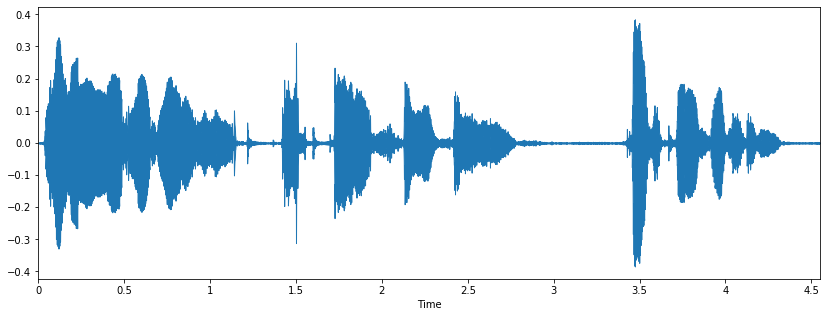

In [82]:
x, sr = librosa.load(sample_audio)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

### Display a spectrogram 

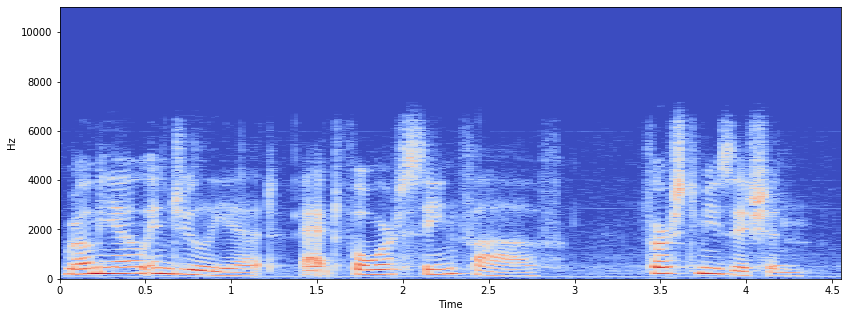

In [83]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [37]:
def extract_mfcc(file_path):
    ''' returns 3D tensor of the mfcc coding from the wav file '''
    file_name = bytes.decode(file_path.numpy())
    mfcc = tf.convert_to_tensor(wav2mfcc(file_name))
    mfcc = tf.expand_dims(mfcc, 2)
    return mfcc

In [44]:
def create_audio_ds(list_ds):
    ''' creates audio dataset containing audio tensors from file list dataset '''
    batch = []
    for f in list_ds:
        audio = extract_mfcc(f)
        batch.append(audio)
    return tf.data.Dataset.from_tensor_slices(batch)

In [45]:
audio_ds = create_audio_ds(list_ds)

In [46]:
# Audio (input) tensor is 3D tensor.
# 20x196 is MFCC encoding. Converting it to 3D for use in CNN layers.
for a in audio_ds.take(1):
    print(a.numpy().shape)

(20, 196, 1)


In [47]:
# Finally, zip the input and labels to a single dataset.
labeled_ds = tf.data.Dataset.zip((audio_ds, speaker_ds))

In [48]:
input_shape = None
output_shape = None
for audio, speaker in labeled_ds.take(1):
    input_shape = audio.numpy().shape
    output_shape = speaker.numpy().shape
    print('input_shape', input_shape)
    print('output_shape', output_shape)

input_shape (20, 196, 1)
output_shape (3985,)


In [49]:
# create train, validation and test datasets.
data_size = sum([1 for _, _ in labeled_ds])
train_size = int(data_size * 0.9)
val_size = int(data_size * 0.05)
test_size = data_size - train_size - val_size
print('all samples: {}'.format(data_size))
print('training samples: {}'.format(train_size))
print('validation samples: {}'.format(val_size))
print('test samples: {}'.format(test_size))

all samples: 65394
training samples: 58854
validation samples: 3269
test samples: 3271


In [50]:
# create batched datasets
batch_size = 32
labeled_ds = labeled_ds.shuffle(data_size, seed=42)
train_ds = labeled_ds.take(train_size).shuffle(1000).batch(batch_size).prefetch(1)
val_ds = labeled_ds.skip(train_size).take(val_size).batch(batch_size).prefetch(1)
test_ds = labeled_ds.skip(train_size + val_size).take(test_size).batch(batch_size).prefetch(1)

## Model and training

In [ ]:
# if previously trained model is on the disk, use it without training.
# the model has millions of parameters and training with 32 epoches
# takes 12hrs+ on my mac. 
train_model = False
model_name = 'spr_model.h5'
model_path = os.path.join('.', model_name)
if os.path.exists(model_path):
    model = K.models.load_model()
else:
    model = create_model()
    train_model = True

In [51]:
def create_model():
    dropout_rate = .25
    regularazation = 0.001
    model = K.models.Sequential()
    model.add(K.layers.Conv2D(16, kernel_size=(3, 3), padding='same', 
                activation='relu',
                input_shape=input_shape))
    model.add(K.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv2D(32, kernel_size=(3, 3), padding='same', 
                activation='relu'))
    model.add(K.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Conv2D(64, kernel_size=(3, 3), padding='same', 
                activation='relu'))
    model.add(K.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Flatten())
    model.add(K.layers.Dropout(dropout_rate))
    model.add(K.layers.Dense(len(speaker2idx) * 2, activation='relu',
                kernel_regularizer=K.regularizers.l2(regularazation)))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dropout(dropout_rate))
    model.add(K.layers.Dense(len(speaker2idx), activation='softmax'))
    model.compile(loss=K.losses.categorical_crossentropy,
              optimizer=K.optimizers.Adam(),
              metrics=['acc'])
    return model

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 196, 16)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 98, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 98, 16)        64        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 98, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 49, 32)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 5, 49, 32)         128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 49, 64)        

In [54]:
if train_model:
    root_logdir = os.path.join(os.curdir, "spr_logs")
    def get_run_dir():
        import time
        run_id = time.strftime("run%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)
    run_logdir = get_run_dir()
    tensorboard_cb = K.callbacks.TensorBoard(run_logdir, update_freq='batch')
    history = model.fit(train_ds, epochs=32, validation_data=val_ds, callbacks=[tensorboard_cb])

## Model Evaluation

In [56]:
model.evaluate(test_ds)

103/103 [==============================] - 13s 122ms/step - loss: 1.3973 - acc: 0.9233


[1.3973080868859893, 0.92326504]

We got 92% accuracy!

In [57]:
if train_model:
    model.save(model_name)

Let's test few files ourselves.

In [67]:
sample_file = [os.path.join(voxforge_root,'mk-20120531-ctv/wav/a0369.wav'),
               os.path.join(voxforge_root,'rocketman768-20080408-axr/wav/b0220.wav')]
sample_ds = tf.data.Dataset.from_tensor_slices(sample_file)
sample_input = create_audio_ds(sample_ds).batch(2)
output = model.predict(sample_input)

1715

In [70]:
speaker_ids = output.argmax(axis=1)
for idx in speaker_ids:
    print('speaker:', idx2speaker[idx])

speaker: mk-20120531-ctv
speaker: rocketman768-20080408-axr


Great! Perfect predictions. Thank you for your time.